In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [163]:
train_data_path = os.getcwd() + '/data/train.csv'
test_data_path = os.getcwd() + '/data/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


In [164]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [165]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
집에 대한 다양한 정보가 들어있는 것으로 보입니다. 이들의 특징을 활용해서 집의 가격을 맞추어

#2. 데이터 EDA

In [166]:
import seaborn as sns

#3.  데이터 전처리

##1) 필요한 데이터만 자르기
- id drop (unnecessary feature)
- date drop(굳이 필요 없음)
- price drop : Target data

In [167]:
train.drop(['id','date','zipcode'], axis=1, inplace=True)

In [168]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


In [169]:
y = train['price']
del train['price']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [170]:
test.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [171]:
test = test.drop(['id','date','zipcode'], axis=1, inplace=False)

In [172]:
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
2,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,47.6561,-122.005,4760,101930
3,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,47.5123,-122.337,1780,8113
4,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,47.3684,-122.031,2390,7570


## 2) Checking the distribution

**Highly skewed 된 데이터의 분포만 바꿔줌 (skewness 절대값 1 이상인 칼럼들)**

- Feature data 에 skewed data 가 있는지 확인
*확인하는 이유 : "Why do we care if the data is skewed? If the response variable is skewed like in Kaggle’s House Prices Competition, **the model will be trained on a much larger number of moderately priced homes, and will be less likely to successfully predict the price for the most expensive houses**. The concept is the same as training a model on imbalanced categorical classes."



---

https://www.geeksforgeeks.org/scipy-stats-skew-python/#:~:text=skew(array%2C%20axis%3D0,right%20tail%20of%20the%20distribution.

####**Skewness**   

:As a general rule of thumb:

If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

- skewness 의 절대값이 1 이상일 경우 심각하게 skew 되었다고 일반적으로 여겨짐
- 하단의 칼럼들 : skewneww 절대값이 1 이상인 칼럼

### (1) train.Skew() 확인

In [195]:
skew=pd.DataFrame(train.skew(), columns=[ 'skew'])
highly_skew=skew[(skew['skew']>1)|(skew['skew']<-1)]
skew_columns = highly_skew.index
highly_skew

,skew
waterfront,11.728113
view,2.960119


In [185]:
train['yr_renovated'].value_counts()

0       14404
2014       71
2013       28
2003       25
2007       25
        ...  
1946        1
1954        1
1976        1
1944        1
1940        1
Name: yr_renovated, Length: 65, dtype: int64

In [186]:
train['yr_built'].value_counts()

2014    405
2006    325
2004    305
2005    302
2003    284
       ... 
1901     21
1933     20
1902     20
1935     19
1934     11
Name: yr_built, Length: 116, dtype: int64

In [187]:
train['yr_built'] = 2019 - train['yr_built']

In [188]:
test['yr_built'] = 2019 - test['yr_built']

In [190]:
train['yr_renovated'] = np.where(train['yr_renovated']>0,2019-train['yr_renovated'],train['yr_built'])

In [191]:
test['yr_renovated'] = np.where(test['yr_renovated']>0,2019-test['yr_renovated'],test['yr_built'])

In [192]:
train['yr_built'].value_counts()

5      405
13     325
15     305
14     302
16     284
      ... 
118     21
86      20
117     20
84      19
85      11
Name: yr_built, Length: 116, dtype: int64

In [194]:
test['yr_renovated'].value_counts()

5      173
14     159
16     149
12     145
42     144
      ... 
118      8
117      7
115      7
86       6
84       5
Name: yr_renovated, Length: 116, dtype: int64

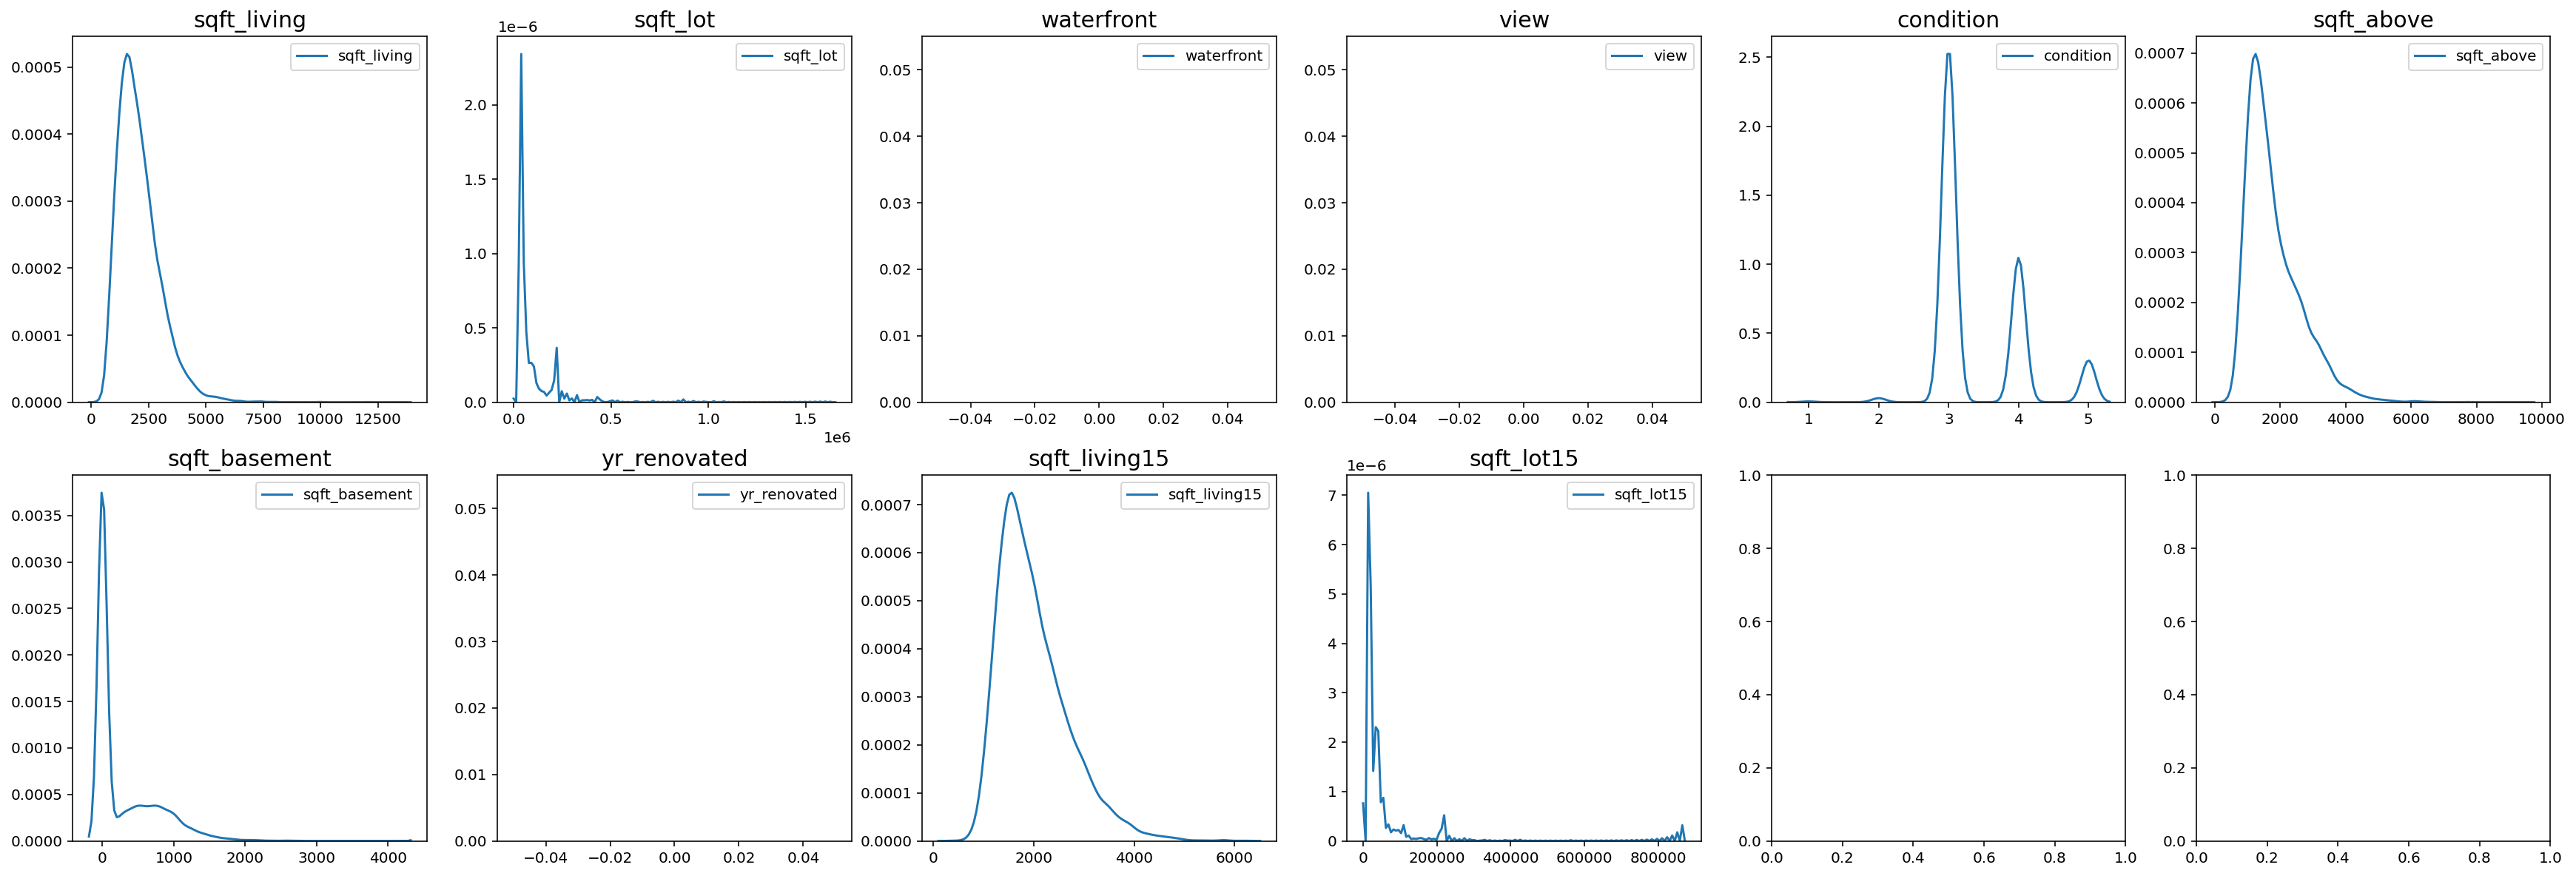

In [174]:
import seaborn as sns
fig, ax = plt.subplots(2, 6, figsize=(30, 10))    
count = 0
for row in range(2):
    for col in range(6):
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 10 :
            break

### (2).Skewed columns log 변환

In [175]:
for c in ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15']:
  train[c]=np.log1p(train[c])

### (3) log 변환 후 분포 시각화 및 skewness 확인

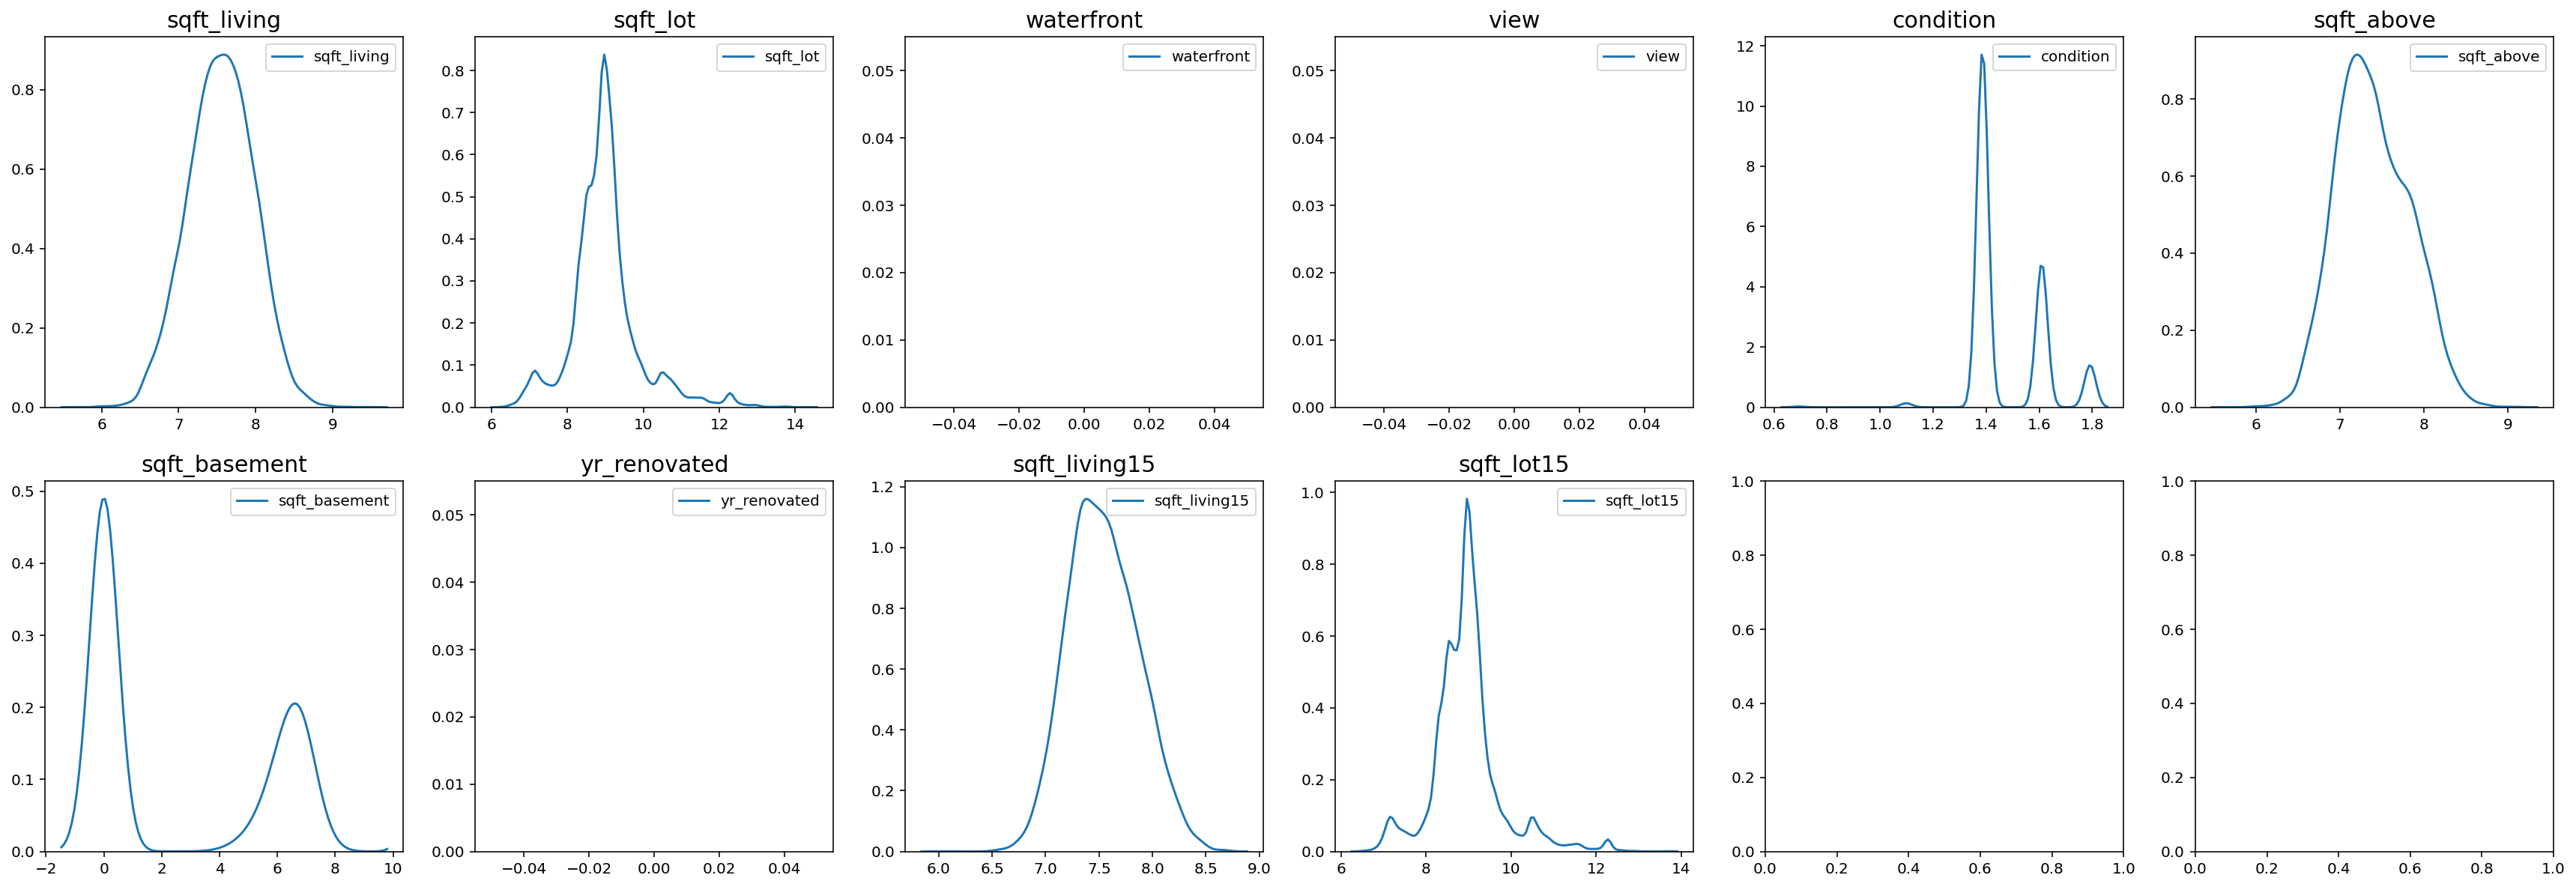

In [176]:
fig, ax=plt.subplots(2,6, figsize=(30,10))
count=0

for ro in range(2):
  for col in range(6):
    sns.kdeplot(train[skew_columns[count]], ax=ax[ro][col])
    ax[ro][col].set_title(skew_columns[count], fontsize=15)

    count+=1
    if count==10:
      break

In [177]:
new_skew=pd.DataFrame(train.skew(), columns=['log_trans_skewed'])
pd.merge(highly_skew,new_skew.loc[skew_columns], left_index=True, right_index=True)

,skew,log_trans_skewed
sqft_living,1.492472,-0.037460
sqft_lot,13.350500,0.989919
waterfront,11.728113,11.728113
view,3.378768,2.960119
condition,1.044110,0.618407
sqft_above,1.429070,0.237412
sqft_basement,1.556555,0.488402
yr_renovated,4.569374,4.569374
sqft_living15,1.125932,0.210766
sqft_lot15,10.028412,0.990273


In [115]:
skew_columns

Index(['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [178]:
for c in ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15']:
  test[c]=np.log1p(test[c])

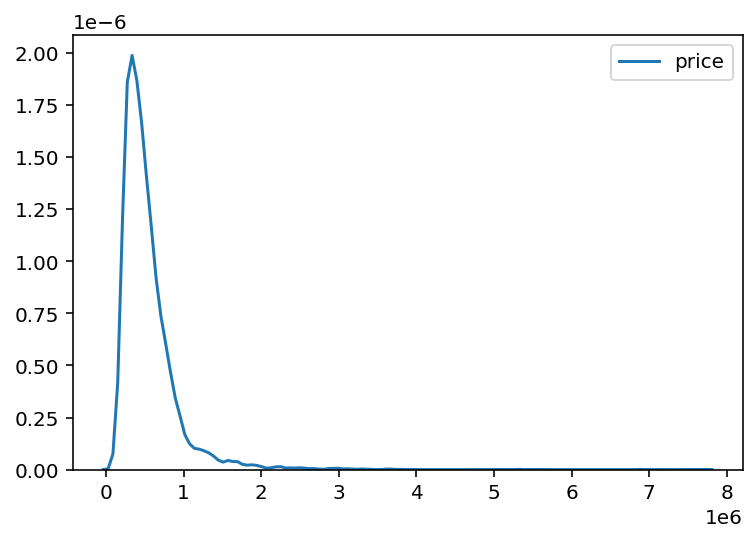

In [179]:
sns.kdeplot(y)
plt.show()

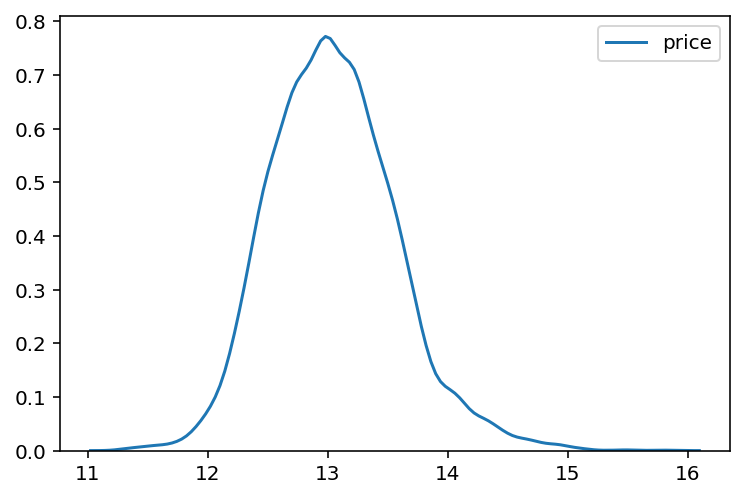

In [180]:
#np.log1p() 함수가 바로 이 역할을 해주는 함수입니다. 그러면 y값이 '-inf' -> '0'으로 바뀌게 되죠. 출처:  [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 3) Null data 확인


In [181]:
train.isna().sum()

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 4) Data type 확인

In [196]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  float64
 3   sqft_lot       15035 non-null  float64
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  float64
 6   view           15035 non-null  float64
 7   condition      15035 non-null  float64
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  float64
 10  sqft_basement  15035 non-null  float64
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  lat            15035 non-null  float64
 14  long           15035 non-null  float64
 15  sqft_living15  15035 non-null  float64
 16  sqft_lot15     15035 non-null  float64
dtypes: float64(13), int64(4)
memory usage: 2.0 MB


#4. Making Model

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [122]:
random_state = 2020 
gboost = GradientBoostingRegressor(random_state=2020)
xgboost = xgb.XGBRegressor(random_state=2020)
lightgbm = lgb.LGBMRegressor(random_state=2020)
rdforest = RandomForestRegressor(random_state=2020)


models = [gboost, xgboost, lightgbm, rdforest]

In [123]:
# 이름 속성 접근 가능
gboost.__class__.__name__

'GradientBoostingRegressor'

In [197]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장/rmse을 위해 각각에 exp()함수 사용
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
    
score_df

,RMSE
XGBRegressor,111735.417662
LGBMRegressor,112807.726622


In [125]:
y_pred[:5]

array([13.25430779, 12.12951032, 12.54899671, 12.86564619, 13.42726685])

In [126]:
y_test[:5]

2286     13.473022
13015    12.206028
5353     12.751303
7027     12.834684
11790    13.509666
Name: price, dtype: float64

In [127]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,127778.481291
RandomForestRegressor,125701.365882
XGBRegressor,113437.365715
LGBMRegressor,113113.358691


In [218]:
random_state = 2020 
xgboost = xgb.XGBRegressor(random_state=2020,alpha= 0.2)
lightgbm = lgb.LGBMRegressor(random_state=2020,alpha= 0.2)

models = [xgboost, lightgbm]

In [154]:
train_2 = train.drop('zipcode',axis=1,inplace=False)
test_2 = test.drop('zipcode',axis=1,inplace=False)

In [219]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [150,200,350],
    'max_depth': [6,10,30,50,-1],
    'learning_rate' : [0.0001, 0.001,0.1,0.01]
}

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    print(model.__class__.__name__)
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results
for model in models:
    result = my_GridSearch(model, train_3, y, param_grid, verbose=2, n_jobs=-1)
    print(result)

XGBRegressor
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished
    learning_rate  max_depth  n_estimators       score      RMSLE
32         0.1000          6           350   -0.027352   0.165385
33         0.1000         10           150   -0.027541   0.165954
34         0.1000         10           200   -0.027553   0.165991
31         0.1000          6           200   -0.027574   0.166056
35         0.1000         10           350   -0.027814   0.166775
30         0.1000          6           150   -0.027895   0.167019
36         0.1000         30           150   -0.028610   0.169144
37         0.1000         30           200   -0.028615   0.169160
38         0.1000         30           350   -0.028626   0.

In [204]:
train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,3.369139,2.115065,7.552362,8.992803,1.498071,0.004933,0.116360,1.473083,7.660725,7.398105,2.521873,47.899568,45.551114,47.560721,-122.213677,7.542604,8.962064
std,0.902721,0.767519,0.425656,0.905809,0.538522,0.058268,0.362031,0.139559,1.179803,0.429372,3.166771,29.407612,28.897591,0.138164,0.141294,0.328778,0.813601
min,0.000000,0.000000,5.673323,6.255750,1.000000,0.000000,0.000000,0.693147,1.000000,5.673323,0.000000,4.000000,4.000000,47.155900,-122.519000,5.991465,6.480045
25%,3.000000,1.750000,7.266129,8.522877,1.000000,0.000000,0.000000,1.386294,7.000000,7.082549,0.000000,22.000000,20.000000,47.472700,-122.328000,7.307202,8.537192
50%,3.000000,2.250000,7.555382,8.938663,1.500000,0.000000,0.000000,1.386294,7.000000,7.359468,0.000000,44.000000,41.000000,47.571900,-122.231000,7.523481,8.937350
75%,4.000000,2.500000,7.848153,9.277672,2.000000,0.000000,0.000000,1.609438,8.000000,7.710205,6.311735,68.000000,65.000000,47.678300,-122.126000,7.766841,9.218011
max,10.000000,8.000000,9.513477,14.317110,3.500000,0.693147,1.609438,1.791759,13.000000,9.149634,8.326275,119.000000,119.000000,47.777600,-121.315000,8.734077,13.677628


In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [220]:
xgboost_gs = xgb.XGBRegressor(random_state=2020
                            ,alpha= 0.1
                            ,learning_rate=0.1
                            ,max_depth=6  
                            ,n_estimators=350)
lightgbm_gs = lgb.LGBMRegressor(random_state=2020   
                            ,alpha= 0.1
                            ,learning_rate=0.1
                            ,max_depth=-1  
                            ,n_estimators=350)
# lightgbm_gs2 = lgb.LGBMRegressor(random_state=2020   
#                             ,alpha= 0.1
#                             ,learning_rate=0.1
#                             ,max_depth=350
#                             ,n_estimators=350)
models=[xgboost_gs,lightgbm_gs]

In [221]:
prediction_avg = AveragingBlending(models,train_3,y,test_3)

In [222]:
sub['price'] = np.expm1(prediction_avg)
sub.to_csv('./sub_avg7.csv')

In [211]:
train_3 = train.drop('yr_built',axis=1,inplace=False)
test_3 = test.drop('yr_built',axis=1,inplace=False)

In [212]:
lightgbm_gs = lgb.LGBMRegressor(random_state=2020
                            ,learning_rate=0.1
                            ,max_depth=10  
                            ,n_estimators=200)
lightgbm_gs.fit(train_3.values,y)   
prediction_lgb = lightgbm_gs.predict(test_3)  
sub['price'] = np.expm1(prediction_lgb)
sub.to_csv('./sub_lgb3.csv')

In [133]:
prediction_lgb

array([13.11004971, 13.12831241, 14.19227475, ..., 13.01622941,
       12.70348909, 13.01735072])

In [134]:
sub['price'] = np.expm1(prediction_lgb)

In [135]:
sub.to_csv('./sub_lgb.csv')

In [60]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)
    
##절대적 거리 보다는 상대적 거리

In [62]:
predictions = AveragingBlending(models,train,y,test)

In [73]:
sub = pd.read_csv("./data/submission.csv",index_col='id')

In [74]:
sub

,price
id,
15035,5.299667e+05
15036,4.307262e+05
15037,1.361677e+06
15038,3.338036e+05
15039,3.089006e+05
...,...
21498,2.478657e+05
21499,4.156358e+05
21500,4.520817e+05


In [65]:
submission = pd.DataFrame({'id':sub['id'], 'price' : np.expm1(predictions)})

In [75]:
sub['price'] = np.expm1(predictions)

In [76]:
sub.to_csv('./blending.csv')

In [66]:
submission

,id,price
0,15035,5.021016e+05
1,15036,4.624262e+05
2,15037,1.295304e+06
3,15038,2.846089e+05
4,15039,3.330938e+05
...,...,...
6463,21498,2.488858e+05
6464,21499,4.221577e+05
6465,21500,4.657135e+05
6466,21501,3.267170e+05


In [67]:
submission.to_csv('./blending.csv')

In [46]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(train.values)
    for mo in models:
        print("Model {} CV score : {:.4f}".format(mo.__class__.__name__, np.mean(cross_val_score(mo, train.values, y)), kf=kfold))

In [ ]:
for m in models : 
  m['model'].fit(x_train, y_train)

[06:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x_train, y_train, test_x)

[06:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
rmse(test_y['price'], y_pred)

62282.62106889945

In [ ]:
test_y

,id,price
0,15035,13.180571
1,15036,12.973230
2,15037,14.124228
3,15038,12.718311
4,15039,12.640778
...,...,...
6463,21498,12.420647
6464,21499,12.937567
6465,21500,13.021620
6466,21501,12.741320


In [ ]:
y_pred
np.expm1(y_pred)

array([ 531038.03749556,  399591.49707406, 1343246.94301859, ...,
        438497.80088379,  337890.00229448,  419101.58295518])

In [ ]:
submission=pd.DataFrame({'id':test_y['id'], 'price' : np.expm1(y_pred)})

In [ ]:
submission.head()

,id,price
0,15035,5.310380e+05
1,15036,3.995915e+05
2,15037,1.343247e+06
3,15038,3.204336e+05
4,15039,3.073569e+05


In [84]:
train_all = pd.concat([train,y],axis=1)
train_corr = train_all.corr()
train_corr.style.background_gradient(cmap='coolwarm')

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.530548,0.641635,0.189463,0.189532,-0.004819,0.086527,0.039060,0.375286,0.532461,0.201876,0.158799,0.022480,-0.162081,-0.011190,0.135802,0.420778,0.167300,0.359946
bathrooms,0.530548,1.000000,0.762770,0.100960,0.508649,0.075452,0.184763,-0.121244,0.666278,0.697572,0.185446,0.503964,0.065054,-0.207500,0.018110,0.227669,0.575099,0.093674,0.552000
sqft_living,0.641635,0.762770,1.000000,0.326958,0.376024,0.083036,0.242662,-0.037735,0.744805,0.867473,0.277304,0.348704,0.058459,-0.223746,0.036476,0.260941,0.746969,0.303916,0.677383
sqft_lot,0.189463,0.100960,0.326958,1.000000,-0.232084,0.077558,0.124185,0.077112,0.187930,0.317639,-0.018134,-0.003294,0.020758,-0.279549,-0.144338,0.375436,0.366494,0.917834,0.145465
floors,0.189532,0.508649,0.376024,-0.232084,1.000000,0.031159,0.029843,-0.257206,0.462598,0.552572,-0.264388,0.490436,0.009691,-0.059107,0.049004,0.126983,0.281866,-0.220965,0.317810
waterfront,-0.004819,0.075452,0.083036,0.077558,0.031159,1.000000,0.334761,0.010091,0.088061,0.067640,0.040272,-0.026523,0.104548,0.028632,-0.014772,-0.037922,0.083078,0.082652,0.172580
view,0.086527,0.184763,0.242662,0.124185,0.029843,0.334761,1.000000,0.047350,0.245035,0.155480,0.201120,-0.066454,0.103687,0.092607,0.006185,-0.077633,0.263069,0.119014,0.344926
condition,0.039060,-0.121244,-0.037735,0.077112,-0.257206,0.010091,0.047350,1.000000,-0.134087,-0.136710,0.150008,-0.353988,-0.061373,-0.004829,-0.017620,-0.106576,-0.082153,0.081445,0.046462
grade,0.375286,0.666278,0.744805,0.187930,0.462598,0.088061,0.245035,-0.134087,1.000000,0.746238,0.064857,0.440608,0.029870,-0.186541,0.112319,0.202130,0.690393,0.185541,0.707412
sqft_above,0.532461,0.697572,0.867473,0.317639,0.552572,0.067640,0.155480,-0.136710,0.746238,1.000000,-0.192870,0.449655,0.032874,-0.287100,-0.018439,0.363379,0.714843,0.298178,0.591185


In [91]:
train_corr[train_corr['price']<0.2]['price']

sqft_lot        0.145465
waterfront      0.172580
condition       0.046462
yr_built        0.076293
yr_renovated    0.127281
zipcode        -0.039195
long            0.054362
sqft_lot15      0.128528
Name: price, dtype: float64

In [92]:
train_2 = train.drop(['zipcode','condition'],axis=1,inplace=False)
test = test.drop('condition',axis=1,inplace=False)

KeyError: "['zipcode'] not found in axis"

In [93]:
test = test.drop('condition',axis=1,inplace=False)

In [86]:
train_2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3,1.00,7.074117,8.639588,1.0,0.0,0.0,1.386294,7,7.074117,0.0,1955,0.0,47.5112,-122.257,7.201171,8.639588
1,2,1.00,6.647688,9.210440,1.0,0.0,0.0,1.386294,6,6.647688,0.0,1933,0.0,47.7379,-122.233,7.908755,8.995041
2,3,2.00,7.427144,8.997271,1.0,0.0,0.0,1.386294,8,7.427144,0.0,1987,0.0,47.6168,-122.045,7.496097,8.923191
3,3,2.25,7.447751,8.827615,2.0,0.0,0.0,1.386294,7,7.447751,0.0,1995,0.0,47.3097,-122.327,7.713785,8.827615
4,3,1.50,6.966967,9.181118,1.0,0.0,0.0,1.386294,7,6.966967,0.0,1963,0.0,47.4095,-122.315,7.409136,9.181118


In [202]:
train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3,1.00,7.074117,8.639588,1.0,0.0,0.0,1.386294,7,7.074117,0.0,64,64,47.5112,-122.257,7.201171,8.639588
1,2,1.00,6.647688,9.210440,1.0,0.0,0.0,1.386294,6,6.647688,0.0,86,86,47.7379,-122.233,7.908755,8.995041
2,3,2.00,7.427144,8.997271,1.0,0.0,0.0,1.386294,8,7.427144,0.0,32,32,47.6168,-122.045,7.496097,8.923191
3,3,2.25,7.447751,8.827615,2.0,0.0,0.0,1.386294,7,7.447751,0.0,24,24,47.3097,-122.327,7.713785,8.827615
4,3,1.50,6.966967,9.181118,1.0,0.0,0.0,1.386294,7,6.966967,0.0,56,56,47.4095,-122.315,7.409136,9.181118


In [201]:
train.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
bedrooms,1.000000,0.530548,0.641635,0.189463,0.189532,-0.004819,0.086527,0.039060,0.375286,0.532461,0.201876,-0.158799,-0.171488,-0.011190,0.135802,0.420778,0.167300
bathrooms,0.530548,1.000000,0.762770,0.100960,0.508649,0.075452,0.184763,-0.121244,0.666278,0.697572,0.185446,-0.503964,-0.539222,0.018110,0.227669,0.575099,0.093674
sqft_living,0.641635,0.762770,1.000000,0.326958,0.376024,0.083036,0.242662,-0.037735,0.744805,0.867473,0.277304,-0.348704,-0.375502,0.036476,0.260941,0.746969,0.303916
sqft_lot,0.189463,0.100960,0.326958,1.000000,-0.232084,0.077558,0.124185,0.077112,0.187930,0.317639,-0.018134,0.003294,0.010843,-0.144338,0.375436,0.366494,0.917834
floors,0.189532,0.508649,0.376024,-0.232084,1.000000,0.031159,0.029843,-0.257206,0.462598,0.552572,-0.264388,-0.490436,-0.505952,0.049004,0.126983,0.281866,-0.220965
waterfront,-0.004819,0.075452,0.083036,0.077558,0.031159,1.000000,0.334761,0.010091,0.088061,0.067640,0.040272,0.026523,-0.002244,-0.014772,-0.037922,0.083078,0.082652
view,0.086527,0.184763,0.242662,0.124185,0.029843,0.334761,1.000000,0.047350,0.245035,0.155480,0.201120,0.066454,0.033375,0.006185,-0.077633,0.263069,0.119014
condition,0.039060,-0.121244,-0.037735,0.077112,-0.257206,0.010091,0.047350,1.000000,-0.134087,-0.136710,0.150008,0.353988,0.389310,-0.017620,-0.106576,-0.082153,0.081445
grade,0.375286,0.666278,0.744805,0.187930,0.462598,0.088061,0.245035,-0.134087,1.000000,0.746238,0.064857,-0.440608,-0.458392,0.112319,0.202130,0.690393,0.185541
sqft_above,0.532461,0.697572,0.867473,0.317639,0.552572,0.067640,0.155480,-0.136710,0.746238,1.000000,-0.192870,-0.449655,-0.464629,-0.018439,0.363379,0.714843,0.298178


In [ ]:
train[c]=np.log1p(train[c])

In [94]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    print(model.__class__.__name__)
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results
for model in models:
    result = my_GridSearch(model, train_2, y, param_grid, verbose=2, n_jobs=5)
    print(result)

XGBRegressor
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:   12.6s finished
    learning_rate  max_depth  n_estimators       score      RMSLE
25         0.1000         10           100   -0.028995   0.170279
23         0.1000          6           150   -0.029022   0.170359
26         0.1000         10           150   -0.029053   0.170451
22         0.1000          6           100   -0.029650   0.172192
20         0.1000          3           150   -0.033221   0.182265
24         0.1000         10            50   -0.035317   0.187928
19         0.1000          3           100   -0.035424   0.188213
21         0.1000          6            50   -0.037434   0.193478
18         0.1000          3            50   -0.045704   0.213784
17         0.0010         10           150 -116.869978  10.

In [95]:
xgboost_gs = xgb.XGBRegressor(random_state=2020
                            ,learning_rate=0.1
                            ,max_depth=10  
                            ,n_estimators=100)
lightgbm_gs = lgb.LGBMRegressor(random_state=2020
                            ,learning_rate=0.1
                            ,max_depth=10  
                            ,n_estimators=150)
models=[xgboost_gs,lightgbm_gs]

In [97]:
predictions = AveragingBlending(models,train_2,y,test)

In [98]:
sub['price'] = np.expm1(predictions)

In [99]:
sub.to_csv('./blending_2.csv')

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장/rmse을 위해 각각에 exp()함수 사용
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
    
score_df

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_csv_path = '{}/submission_{}RMSE.csv'.format(data_dir, '62282')
print(submission_csv_path)

/root/aiffel/kaggle_kakr_housing/data/submission_62282RMSE.csv


In [ ]:
submission.to_csv(submission_csv_path, index=False)

FileNotFoundError: ignored

In [ ]:
submission.to_csv("submission_62282.csv")

In [ ]:
from google.colab import files
files.download('example.txt') 

In [ ]:
import os
os.getcwd()

'/content'